In [14]:
%load_ext autoreload
%autoreload 2

from importlib import reload
import util
import lanczos
# reload(util)
# reload(lanczos)
from util import create_poly_decay_matvec, create_G_matvec, plot_results, calculate_gaps, eigen_diag_desc, collect_ritz_values, plot_eigenvalues
from sketch.sketch_gaussian import GaussianSketcher
from sketch.sketch_srft import SRFTSketcher
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


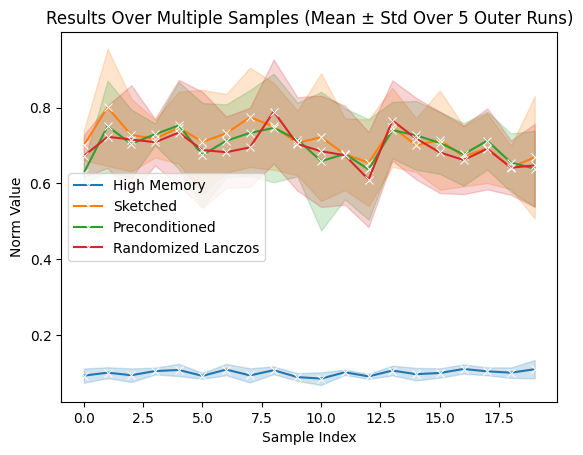

In [16]:
p = 2000
k = 20
s = 40
#### rfft = False while using the randomized Lanczos
srft = SRFTSketcher(p=p, s=s, rfft=False)
gaussian = GaussianSketcher(p=p, s=s)
sketch=gaussian
verbose = False
G_matvec = create_poly_decay_matvec(n=p, R=10, d=1)

df = plot_results(G_matvec, p=p, k=k, k0=5, sketch=sketch, with_plot=True, verbose=verbose)

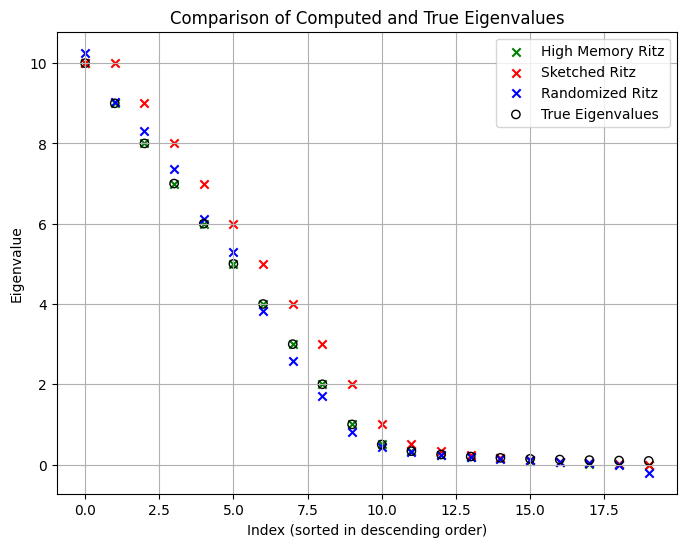

In [17]:
L0, L_sketched, L_randomized, real_eigens = collect_ritz_values(p=p, k=k, G_matvec=G_matvec, sketch=sketch, verbose=verbose)
plot_eigenvalues(L0, L_sketched, L_randomized, real_eigens, False)

In [18]:
import numpy as np
def create_decay_matvec(n, decay_factor=100):
    """
    Create a matrix-vector product function for a diagonal matrix with exponentially decaying eigenvalues.

    Parameters
    ----------
    n : int
        Dimension of the matrix.
    decay_factor : float, optional
        Factor by which consecutive eigenvalues decay, defaults to 10.

    Returns
    -------
    function
        A function that takes a vector x of shape (n,) and returns the product of
        the decay matrix and x.
    """
    # Precompute the diagonal values once (eigenvalues that decay exponentially)
    diag_vals = np.array([decay_factor**(-i) for i in range(-2, n-2)])

    # Define the matrix-vector product function using the precomputed diagonal
    def decay_matvec(x):
        if len(x) != n:
            raise ValueError(f"Vector x must have length {n}.")
        return diag_vals * x
    return decay_matvec

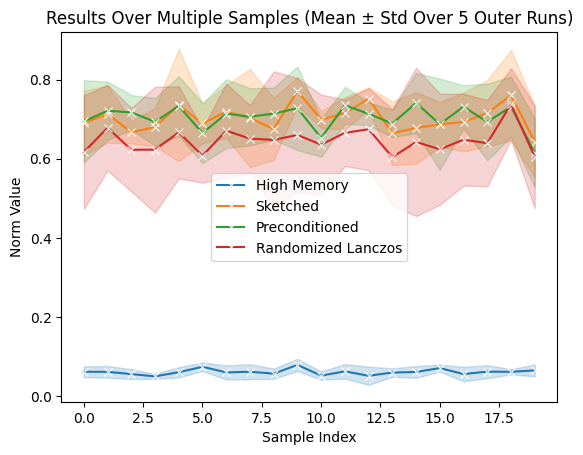

In [20]:
import numpy as np
p = 2000
k = 20
s = 40
#### rfft = False while using the randomized Lanczos
srft = SRFTSketcher(p=p, s=s, rfft=False)
gaussian = GaussianSketcher(p=p, s=s)
sketch=srft
verbose = False
G_matvec = create_decay_matvec(n=p)

df = plot_results(G_matvec, p=p, k=k, k0=5, sketch=sketch,num_samples=20, with_plot=True, verbose=False)

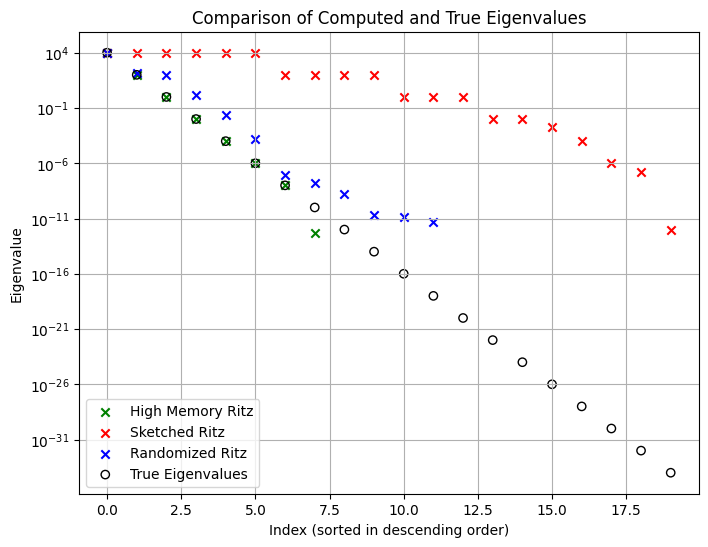

In [21]:
L0, L_sketched, L_randomized, real_eigens = collect_ritz_values(p=p, k=k, G_matvec=G_matvec, sketch=sketch, verbose=verbose)
plot_eigenvalues(L0, L_sketched, L_randomized, real_eigens, ylog=True)

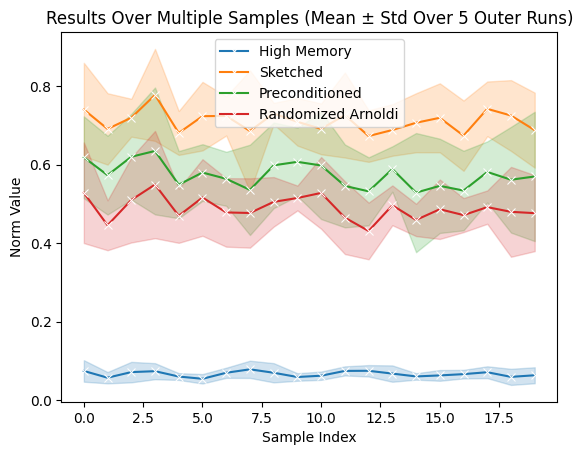

In [22]:
p = 2000
k = 20
s = 40
#### rfft = False while using the randomized Lanczos
srft = SRFTSketcher(p=p, s=s, rfft=False)
gaussian = GaussianSketcher(p=p, s=s)
sketch=srft
verbose = False
G_matvec = create_poly_decay_matvec(n=p, R=10, d=0)

df = plot_results(G_matvec, p=p, k=k, k0=5, sketch=sketch, with_plot=True, verbose=verbose)

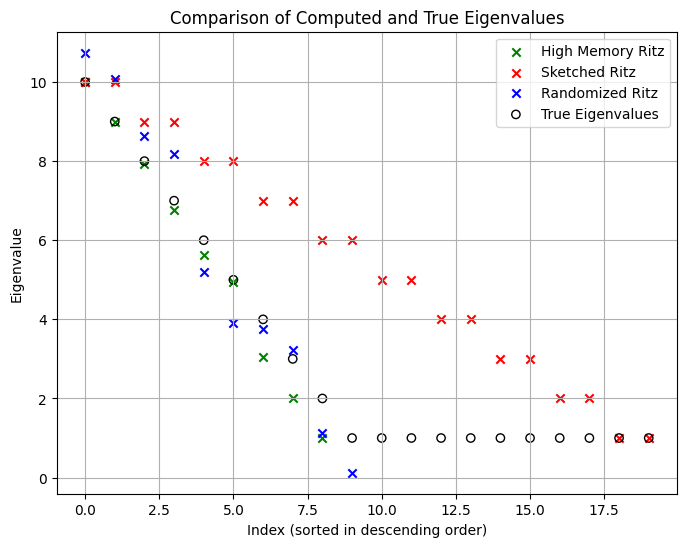

In [28]:
L0, L_sketched, L_randomized, real_eigens = collect_ritz_values(p=p, k=k, G_matvec=G_matvec, sketch=sketch, verbose=verbose)
plot_eigenvalues(L0, L_sketched, L_randomized, real_eigens, False)

In [35]:
def summarize_results(create_op, p_values, k_values, k0, num_samples = 10, verbose = False):
    """
    Parameters:
        create_op : function
            Higher-order function returning a matrix-vector product function for given matrix size n.
        p_values : list of int
            Dimensions of the matrices to test.
        k_values : list of int
            Lanczos iterations to test.
        k0 : int
            Base number of iterations for preconditioning.
    """
    results = [] 
    for p in p_values:
        for k in k_values:
            s = 2 * k
            srft = SRFTSketcher(p=p, s=s, rfft=False)
            gaussian = GaussianSketcher(p=p, s=s)
            
            # def G_matvec(v):
            #     return poly_decay_matvec(v, n=p)
            G_matvec = create_op(n=p)

            for sketch, sketch_name in [(srft, 'SRFT'), (gaussian, 'Gaussian')]:

                # Run the experiment
                df = plot_results(G_matvec=G_matvec, p=p, k=k, k0=k0, sketch=sketch, num_samples=num_samples, with_plot=False, verbose=verbose)
                gap_results = calculate_gaps(df)

                # Store the results
                results.append({
                    'p': p,
                    'k': k,
                    'Sketch Method': sketch_name,
                    'Error Sketched': gap_results['Sketched'],
                    f'Error Precond. (k0={k0})': gap_results['Preconditioned'],
                    # 'Error Post Sketched': gap_results['Post Sketched'],
                    'Error Randomized Arnoldi': gap_results['Randomized Arnoldi'],
                    'Baseline Lanczos': gap_results['High Memory'],
                })

    # Convert results to DataFrame for analysis and display
    results_df = pd.DataFrame(results)

    # Display the results table
    return results_df

### Polynomial Decay

In [36]:
p_values = [1000, 5000, 10000]
k_values = [20, 40, 60]
# p_values = [1000, 2000]
# k_values = [20, 40]
k0 = 10
df = summarize_results(create_poly_decay_matvec, p_values, k_values, k0,verbose=False)

In [37]:
df[df["Sketch Method"] == "SRFT"]

,p,k,Sketch Method,Error Sketched,Error Precond. (k0=10),Error Randomized Arnoldi,Baseline Lanczos
0,1000,20,SRFT,0.559 ± 0.031,0.544 ± 0.024,0.544 ± 0.033,0.141 ± 0.012
2,1000,40,SRFT,0.502 ± 0.027,0.513 ± 0.022,0.501 ± 0.023,0.200 ± 0.012
4,1000,60,SRFT,0.463 ± 0.021,0.464 ± 0.015,0.464 ± 0.028,0.244 ± 0.008
6,5000,20,SRFT,0.647 ± 0.035,0.651 ± 0.034,0.649 ± 0.039,0.062 ± 0.004
8,5000,40,SRFT,0.607 ± 0.018,0.616 ± 0.023,0.615 ± 0.022,0.088 ± 0.006
10,5000,60,SRFT,0.595 ± 0.019,0.598 ± 0.020,0.595 ± 0.018,0.110 ± 0.003
12,10000,20,SRFT,0.643 ± 0.046,0.650 ± 0.037,0.654 ± 0.035,0.045 ± 0.005
14,10000,40,SRFT,0.641 ± 0.021,0.633 ± 0.022,0.640 ± 0.025,0.064 ± 0.003
16,10000,60,SRFT,0.626 ± 0.017,0.630 ± 0.030,0.634 ± 0.023,0.077 ± 0.002


In [38]:
df[df["Sketch Method"] == "Gaussian"]

,p,k,Sketch Method,Error Sketched,Error Precond. (k0=10),Error Randomized Arnoldi,Baseline Lanczos
1,1000,20,Gaussian,0.563 ± 0.057,0.583 ± 0.061,0.587 ± 0.063,0.139 ± 0.006
3,1000,40,Gaussian,0.501 ± 0.048,0.502 ± 0.048,0.508 ± 0.053,0.205 ± 0.005
5,1000,60,Gaussian,0.489 ± 0.030,0.493 ± 0.026,0.502 ± 0.030,0.241 ± 0.007
7,5000,20,Gaussian,0.634 ± 0.057,0.633 ± 0.063,0.624 ± 0.059,0.060 ± 0.003
9,5000,40,Gaussian,0.596 ± 0.045,0.615 ± 0.040,0.605 ± 0.051,0.089 ± 0.005
11,5000,60,Gaussian,0.596 ± 0.021,0.594 ± 0.020,0.600 ± 0.030,0.107 ± 0.004
13,10000,20,Gaussian,0.648 ± 0.062,0.659 ± 0.072,0.659 ± 0.038,0.044 ± 0.004
15,10000,40,Gaussian,0.658 ± 0.044,0.665 ± 0.040,0.662 ± 0.049,0.063 ± 0.002
17,10000,60,Gaussian,0.634 ± 0.033,0.625 ± 0.036,0.633 ± 0.019,0.077 ± 0.003


### G with well-seperated eigenvalues

In [39]:
p_values = [1000, 5000, 10000]
k_values = [20, 40, 60]
k0 = 10
df = summarize_results(create_G_matvec, p_values, k_values, k0)

In [40]:
df[df["Sketch Method"] == "SRFT"]

,p,k,Sketch Method,Error Sketched,Error Precond. (k0=10),Error Randomized Arnoldi,Baseline Lanczos
0,1000,20,SRFT,0.572 ± 0.040,0.567 ± 0.027,0.569 ± 0.043,0.139 ± 0.009
2,1000,40,SRFT,0.503 ± 0.030,0.505 ± 0.032,0.502 ± 0.035,0.194 ± 0.010
4,1000,60,SRFT,0.454 ± 0.028,0.455 ± 0.017,0.458 ± 0.017,0.243 ± 0.008
6,5000,20,SRFT,0.644 ± 0.053,0.638 ± 0.035,0.646 ± 0.039,0.062 ± 0.005
8,5000,40,SRFT,0.606 ± 0.028,0.604 ± 0.033,0.609 ± 0.034,0.092 ± 0.005
10,5000,60,SRFT,0.596 ± 0.021,0.600 ± 0.022,0.600 ± 0.023,0.110 ± 0.005
12,10000,20,SRFT,0.656 ± 0.045,0.659 ± 0.045,0.672 ± 0.036,0.045 ± 0.004
14,10000,40,SRFT,0.658 ± 0.023,0.642 ± 0.031,0.650 ± 0.020,0.063 ± 0.003
16,10000,60,SRFT,0.650 ± 0.012,0.642 ± 0.016,0.650 ± 0.022,0.078 ± 0.003


In [41]:
df[df["Sketch Method"] == "Gaussian"]

,p,k,Sketch Method,Error Sketched,Error Precond. (k0=10),Error Randomized Arnoldi,Baseline Lanczos
1,1000,20,Gaussian,0.573 ± 0.064,0.578 ± 0.040,0.576 ± 0.045,0.146 ± 0.008
3,1000,40,Gaussian,0.528 ± 0.017,0.525 ± 0.026,0.536 ± 0.038,0.195 ± 0.009
5,1000,60,Gaussian,0.466 ± 0.022,0.472 ± 0.020,0.478 ± 0.031,0.242 ± 0.008
7,5000,20,Gaussian,0.642 ± 0.053,0.656 ± 0.054,0.656 ± 0.054,0.063 ± 0.004
9,5000,40,Gaussian,0.602 ± 0.037,0.593 ± 0.037,0.593 ± 0.028,0.090 ± 0.005
11,5000,60,Gaussian,0.595 ± 0.022,0.600 ± 0.020,0.597 ± 0.021,0.108 ± 0.002
13,10000,20,Gaussian,0.665 ± 0.059,0.657 ± 0.057,0.667 ± 0.047,0.043 ± 0.004
15,10000,40,Gaussian,0.646 ± 0.021,0.648 ± 0.035,0.652 ± 0.043,0.064 ± 0.004
17,10000,60,Gaussian,0.645 ± 0.034,0.639 ± 0.035,0.637 ± 0.031,0.076 ± 0.003
